<a href="https://colab.research.google.com/github/shinhs0920/Engineering-computing-application/blob/master/Attention(seq2seq).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#어텐션 메커니즘(Attention Mechanism)

앞의 seq2seq 모델은 인코더에서 입력 시퀀스를 컨텍스트 벡터라는 하나의 고정된 크기의 벡터 표현으로 압축하고, 디코더는 이 컨텍스트 벡터를 통해서 출력 시퀀스를 만들어냈습니다.

하지만 이러한 RNN에 기반한 seq2seq 모델에는 크게 두 가지 문제가 있습니다.

첫째,하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하니까 정보 손실이 발생합니다.
<br>둘째, RNN의 고질적인 문제인 기울기 소실(Vanishing Gradient) 문제가 존재합니다.

결국 이는 기계 번역 분야에서 입력 문장이 길면 번역 품질이 떨어지는 현상이 나타납니다

위 현상의 대안으로 입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 것을 보정해주기 위한 등장한 기법이 어텐션(attention) 입니다.

##1. 어텐션

 디코더에서 출력 단어를 예측하는 매 시점(time step)마다, 인코더에서의 전체 입력 문장을 다시 한 번 참고하고 검토합니다. 

 전체 입력 문장을 전부 다 동일한 비율로 참고하는 것이 아니라, 해당 시점에서 예측해야할 단어와 연관이 있는 입력 단어 부분을 좀 더 집중(attention)해서 보게 됩니다.


##2. 어텐션 함수(Attention function)

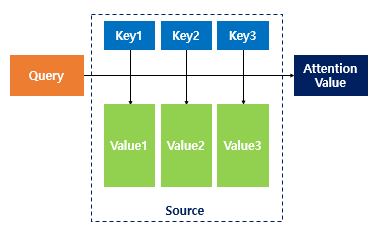

어텐션을 함수로 표현한다면, 다음과 같이 표현됩니다.

**Attention(Q, K, V) = Attention Value**

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다. <br>그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영해줍니다. <br>그리고 유사도가 반영된 '값(Value)'을 모두 더해서 리턴합니다. 여기서는 이를 어텐션 값(Attention Value)이라고 하겠습니다.

seq2seq & 어텐션 모델에서 Q, K, V에 해당되는 각각의 Query, Keys, Values는 각각 다음과 같습니다.

Q = Query : t-1 시점의 디코더 셀에서의 은닉 상태
<br> K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
<br>V = Values : 모든 시점의 인코더 셀의 은닉 상태들

## 닷-프로덕트 어텐션(Dot-Product Attention)

어텐션 종류 중 가장 이해하기 쉽게 수식을 적용한 어텐션은 닷-프로덕트 어텐션(Dot-Product Attention)입니다. seq2seq에서 사용되는 어텐션 중에서 닷-프로덕트 어텐션과 다른 어텐션의 차이는 중간 수식의 차이입니다. 메커니즘 자체는 거의 유사합니다.

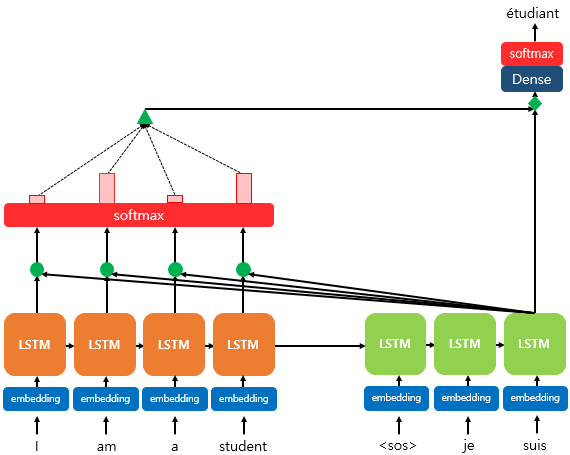

위 그림은 디코더의 세번째 LSTM 셀에서 출력 단어 예측 시, 어텐션 메커니즘을 사용하는 모습입니다. 
<BR> 디코더의 세번째 LSTM 셀은 출력 단어를 예측하기 위해서 인코더의 모든 입력 단어들의 정보를 다시 한번 참고합니다. 위 그림에서 주목할 것은 인코더의 소프트맥스 함수입니다.

소프트맥스 함수의 결과값은 I, am, a, student 단어 각각이 출력 단어를 예측할 때 얼마나 도움이 되는지를 수치화한 값입니다. 
<BR>빨간 직사각형의 크기로 소프트맥스 함수의 결과값의 크기를 표현했습니다. <BR>직사각형의 크기가 클 수록 도움이 되는 정도의 크기가 큽니다. 

각 입력 단어가 디코더의 예측에 도움이 되는 정도가 수치화되어 측정되면 이를 하나의 정보로 담아서 디코더로 전송됩니다. 
<BR>위의 그림에서는 초록색 삼각형이 이에 해당됩니다.
<br> 결과적으로, 디코더는 출력 단어를 더 정확하게 예측할 확률이 높아집니다.

### 1.어텐션 스코어(Attention Score)를 구한다.

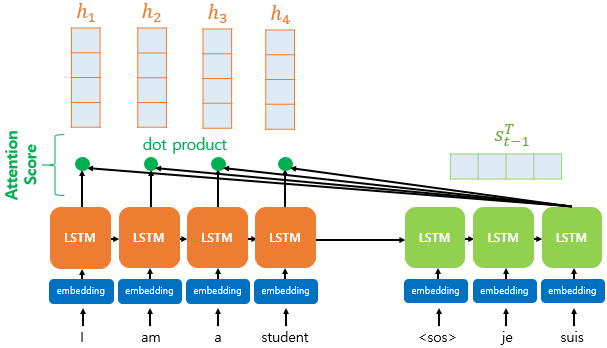

인코더의 시점(time step)을 각각 1, 2, ... t라고 하였을 때 인코더의 은닉 상태(hidden state)를 각각 h1, h2, ... hN라고 했습니다. 
<br>디코더의 현재 시점(time step) t에서의 디코더의 은닉 상태(hidden state)를 st라고 합니다.
<br> 또한 여기서는 "인코더의 은닉 상태 차원 = 디코더의 은닉 상태의 차원" 이라고 가정합니다. 위의 그림의 경우에는 동일하게 크기가 4입니다.

시점 t에서 출력 단어를 예측하기 위해서 디코더의 셀은 두 개의 입력값을 필요로 하는데, 바로 이전 시점인 t-1의 은닉 상태와 이전 시점 t-1에 나온 출력 단어입니다. 

그런데 어텐션 메커니즘에서는 이를 예측하기위해 어텐션 값(Attention Value)이라는 새로운 값이 필요합니다.
<br> t번째 단어를 예측하기 위한 어텐션 값을 at이라고 정의합니다.

어텐션 스코어(Attention Score)를 구하겠습니다. 
<br>어텐션 스코어란 현재 디코더의 시점 t에서 단어를 예측하기 위해, 인코더의 모든 은닉 상태 각각이 디코더의 바로 전 시점의 은닉 상태 st−1와 얼마나 유사한지를 판단하는 스코어값 입니다.

닷-프로덕트 어텐션에서는 이 스코어 값을 구하기 위해 st−1를 전치(Transpose)하고 각각의 은닉 상태와 내적(dot product)을 수행합니다. 즉, 모든 어텐션 스코어의 값은 스칼라입니다. 예를 들어 st−1과 인코더의 i번째 은닉 상태의 어텐션 스코어의 계산 방법은 아래의 그림과 같습니다

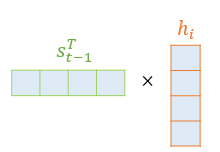

### 2) 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.

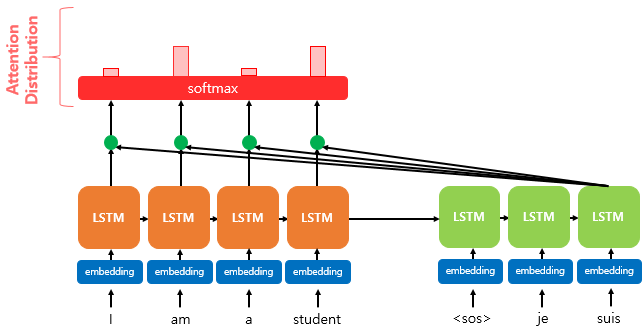

$e^t$ 에 소프트맥스 함수를 적용하여, 모든 값을 합하면 1이 되는 확률 분포를 얻어냅니다. 이를 어텐션 분포(Attention Distribution)라고 하며, 각각의 값은 어텐션 가중치(Attention Weight)라고 합니다. 
<br>예를 들어 소프트맥스 함수를 적용하여 얻은 출력값인 I, am, a, student의 어텐션 가중치를 각각 0.1, 0.4, 0.1, 0.4라고 하면, 이들의 합은 1입니다.
<br> 위의 그림은 각 인코더의 은닉 상태에서의 어텐션 가중치의 크기를 직사각형의 크기를 통해 시각화하였습니다. 즉, 어텐션 가중치가 클수록 직사각형이 큽니다.

디코더의 시점 t에서의 어텐션 가중치의 모음값인 어텐션 분포를 $α^t$이라고 할 때, $α^t$을 식으로 정의하면 다음과 같습니다.

$α^t$=softmax($e^t$)

###3) 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다.

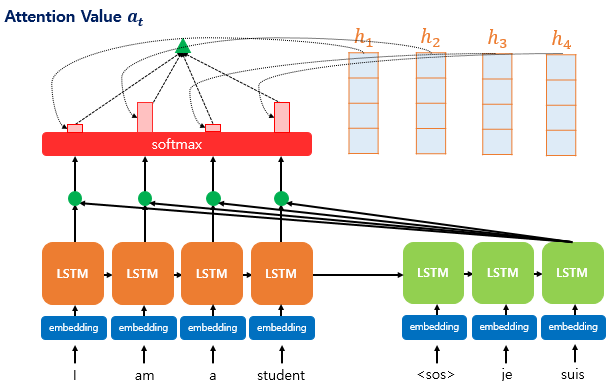

지금까지의 정보들을 하나로 합칩니다. 어텐션의 최종 결과값을 얻기 위해서 각 인코더의 은닉 상태와 어텐션 가중치값들을 곱하고, 최종적으로 모두 더합니다. <br> 이를, 가중합(Weighted Sum)이라고 합니다. 

이러한 어텐션 값 $a^t$은 종종 컨텍스트 벡터(context vector)라고도 불립니다. 앞의 가장 기본적인 seq2seq에서는 인코더의 마지막 은닉 상태를 컨텍스트 벡터라고 부른다면, 이곳 어텐션 메커니즘에서는 $a^t$ 를 컨텍스트 벡터라고 부릅니다.

### 4)어텐션 값과 디코더의 t-1 시점의 은닉 상태를 결합한다.(Concatenate)

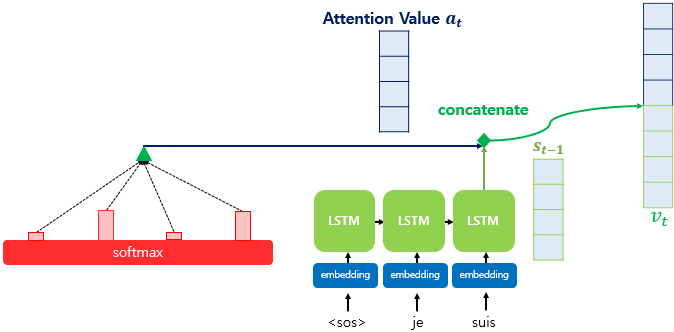

어텐션 값이 구해지면 어텐션 메커니즘은 at를 st−1와 결합(concatenate)하여 하나의 벡터로 만드는 작업을 수행합니다.
<br> 이를 vt라고 정의해보겠습니다.

기존의 RNN 셀이 다음 단어를 예측하는 메커니즘을 그대로 사용하면 됩니다.
<br>단지, 원래 현재 t 시점의 은닉 상태를 계산하기 위해서 사용하던 ***s<sub>t−1<sub>*** 대신 ***v<sub>t<sub>*** 을 사용합니다.   